## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import re
import math
from IPython.display import display_html
from itertools import chain,cycle
from scipy import stats
import scipy
from scipy.stats import mannwhitneyu
from pandas.core.common import flatten

## Function Definitions

In [2]:
def replace_str_list(string_list):
    '''
    INPUT -  string_list - string-formatted list enclosed in {} and separated by ,
    OUTPUT - List of strings
    '''
    lst = string_list.replace('{', '').replace('}', '').replace('"', '').split(',')
    if lst == '':
        return None
    else:
        return lst

In [3]:
def highlight_significant(row): 
    '''
    INPUT - row - row of dataframe with a 'p-value' column
    OUTPUT -  CSS highlighting of dataframe row with significant p-value 
    '''
    highlight = 'background-color: lightcoral;'
    default = ''
    
    # Only highlight p-values of rows where p-value is significant
    if row['p-value'] <= 0.05:
        return [highlight]
    else:
        return [default]

In [4]:
def currency_to_float(price_dollars):
    '''
    INPUT - price_dollars - price as srting in Dollars including currency
    OUTPUT - price as a float rounded to 2 digits
            
    '''
    return round(float(re.sub(r'[\$,]', '', price_dollars)),2)

In [5]:
def get_mean_nan(df):
    '''
    INPUT - df - dataframe with data
    OUTPUT - column_perc_nan - percentage of null values in each column of the dataframe 
    '''
    column_perc_nan = (df.isnull().mean()*100).to_frame().reset_index()
    column_perc_nan.columns = ['attribute', 'percentage']
    return column_perc_nan

In [6]:
def split_dictionary_col(df, col_name):
    '''
    INPUT - df - dataframe containning string-formatted list column
          - col_name - string-formatted list column to be unpacked into different binary columns
    OUTPUT -  dataframe with row values converted to binary columns   
    '''
    temp_col = 'list_' + col_name
    # Transform string-formatted list to a list of stings
    df[temp_col] = df[col_name].apply(lambda d: replace_str_list(d))
    # Get the unique values by flattening all lists and transforming to a set 
    unique_vals = set(flatten(df[temp_col].to_list()))
    unique_vals = [v for v in unique_vals]
    
    # Remove empty strings from list
    if '' in unique_vals:
        unique_vals.remove('')
    
    for value in unique_vals:
        cat_col_name = 'has_' + value.lower().replace(' ', '_')
        # Create new columns in dataframe with binary encoding of list values
        df[cat_col_name] = df[temp_col].apply(lambda l: 1 if value in l else 0)
        
    df.drop(columns=[temp_col], inplace=True)

In [7]:
def get_percentage_nan(df_seattle, df_boston):
    '''
    INPUT - df_seattle - dataframe of Seatlle listings/calendar data
          - df_boston - dataframe of Boston listings/calendar data
    OUTPUT - concatenated dataframe containing the percentage of NAN values in the input dataframe
    '''
    column_perc_nan_seattle = get_mean_nan(df_seattle)
    column_perc_nan_boston = get_mean_nan(df_boston)

    # Add a column denoting the city, this necessary for the argument 'hue' in seaborn
    column_perc_nan_seattle['city'] = 'Seattle'
    column_perc_nan_boston['city'] = 'Boston'

    return pd.concat([column_perc_nan_seattle, column_perc_nan_boston]) 

In [8]:
def plot_nan_column_percentages(df, datasource):
    '''
    INPUT - df - dataframe containning percentages of NAN values in listings/calendar dataframes
          - datasource - name of the data source (listing, dataframe)
    '''
    sns.set(rc={'figure.figsize':(10,5)})
    
    graph = sns.barplot(x="attribute", y="percentage", hue="city", data=df[df['percentage']>0], palette="mako")  
    graph.set(title='Percentage of missing values per column in '+ datasource)
    graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

In [9]:
def get_top_corr_columns(top_nr, df, all_columns):
    '''
    INPUT - top_nr - number of top correlation values to return
          - df - dataframe to calculate the column correlations for
          - all_columns - column names to take into account in the Pearson correlation analysis
    OUTPUT - sorted list of top_nr correlating columns with the price column
    '''
    correlations = np.corrcoef(df[all_columns].values.T)
    corr_price = correlations[0]
    
    # Get the indices of the top_nr highest correlation values (absolute value) with the variable 'price'
    sorted_indices = np.argsort(np.absolute(corr_price))[-(top_nr + 1):]
    selected_columns = [all_columns[i] for i in  sorted_indices]
    return sorted(selected_columns)

In [10]:
def display_side_by_side(*args, titles = cycle([''])):
    '''
    INPUT - args - dataframes to be displayed as side-by-side tables
          - titles - tittles of the tables to be drawn
    '''
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [11]:
def extract_date(df):
    '''
    INPUT - df - dataframe containing a string-formatted 'date' column to be converted to datetime and extracted into 'month' and 'year' columns
    '''
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['month'] = df['date'].apply(lambda d: d.month)
    df['year'] = df['date'].apply(lambda d: d.year)

In [12]:
def draw_holiday(day_of_year, description, graph, color, position):
    '''
    INPUT - day_of_year - day of the year
          - description - name of the holiday
          - graph - graph variable to draw to
          - color - color of the axis to be drawn
          - position - position of the axis to be drawn, value in {top, bottom}
    '''
    # Add vertical line for each holiday 
    plt.axvline(day_of_year, color=color, linestyle='--')
    
    # Adjust position of text
    if position == 'top':
        position_y = 0.8
    else:
        position_y = 0.08
    
    # Add name of each holiday
    graph.text(day_of_year -3, position_y, description , fontsize=9, rotation=90, color=color)

In [13]:
def col_to_binary(df, column, unique_values):
    '''
    INPUT - df - dataframe containing a list column to unpack into binary columns
          - column - single list column to unpack into binary columns
          - unique_values - unique values of all possible values in 'column'
    OUTPUT -       
    '''
    for value in unique_values:
        # Return 1 if unique value is in list column, otherwise 0
        df[column + '_' + value] = df[column].apply(lambda l: 1 if l == value else 0)

# I. Business Understanding

Airbnb <em>"is an American company that operates an online marketplace for lodging, primarily homestays for vacation rentals, and tourism activities"</em> (Source [Wikipedia](https://en.wikipedia.org/wiki/Airbnb)). Over the years Airbnb has become the go-to platform for affordable rentals and unique travel stays. In this notebook, we analyse Airbnb listings from two cities (Boston and Seattle) from the perspective of a user. The user's interst is focused on analysing availability and price fluctuations of accommodations to better plan their budget and vacation period.\
\
Our aim is to provide answers to the following questions: 

#### Q1:  How do the prices compare between Boston and Seattle?
#### Q2:  Which time of year is availability lowest in both cities?
#### Q3:  How do neighborhood and amenities affect with price?

# II. Data Understanding

### 1. Data access and exploration

In [14]:
# Load listings and calendar data from .csv files
df_listing_seattle = pd.read_csv('airbnb_seattle/listings.csv')
df_listing_boston = pd.read_csv('airbnb_boston/listings.csv')

df_calendar_seattle = pd.read_csv('airbnb_seattle/calendar.csv')
df_calendar_boston = pd.read_csv('airbnb_boston/calendar.csv')

print('Seattle listings :', df_listing_seattle.shape, 'Boston listings: ', df_listing_boston.shape)
print('Seattle calendar :', df_calendar_seattle.shape, 'Boston calendar: ', df_calendar_boston.shape)

Seattle listings : (3818, 92) Boston listings:  (3585, 95)
Seattle calendar : (1393570, 4) Boston calendar:  (1308890, 4)


In [15]:
# Load list of relevant holidays in the states of Washington and Massachusetts for the years 2016-2017 according to periods in calendar.csv
holidays_seattle = pd.read_csv('holidays_seattle/holidays_seattle.csv')
holidays_boston = pd.read_csv('holidays_boston/holidays_boston.csv')

In [16]:
# Get common columns between the Seattle and the Boston listing datasets and keep only these common columns
listing_intersection = list(set(df_listing_seattle.columns) & set(df_listing_seattle.columns))
df_listing_seattle = df_listing_seattle[listing_intersection]
df_listing_boston = df_listing_boston[listing_intersection]

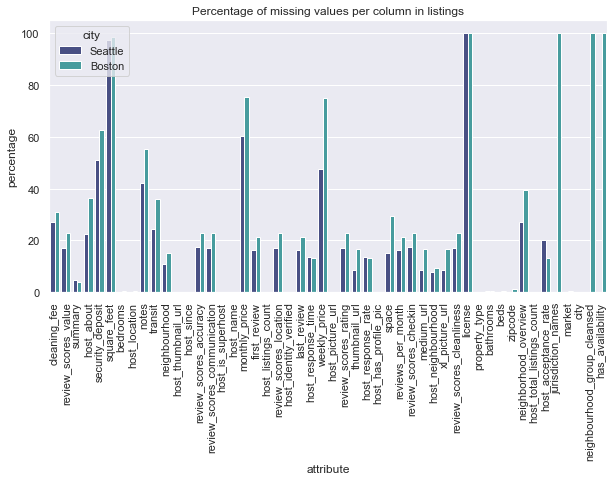

In [17]:
# Plot the percentage of NAN vlaues in the listings dataset columns (columns that are 100% filled are not depicted)
listings_nan_cities = get_percentage_nan(df_listing_seattle, df_listing_boston)
plot_nan_column_percentages(listings_nan_cities, 'listings')
plt.savefig('figures/nan_listings_columns.pdf', bbox_inches='tight')

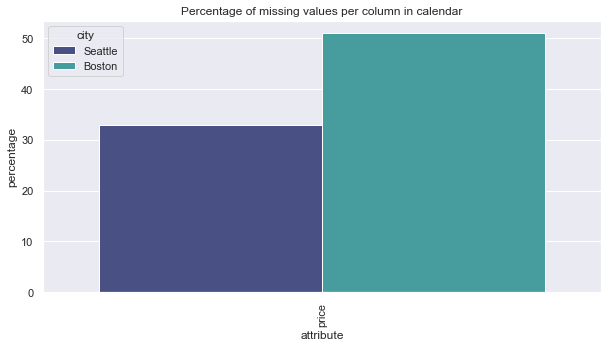

In [18]:
# Plot the percentage of NAN vlaues in the calendar dataset columns (columns that are 100% filled are not depicted)
calendar_nan_cities = get_percentage_nan(df_calendar_seattle, df_calendar_boston)
plot_nan_column_percentages(calendar_nan_cities, 'calendar')
plt.savefig('figures/nan_calendar_columns.pdf')

# III. Data preparation

##  1. Data cleaning:

In [19]:
# Drop columns with more than 60% of values missing 
col_to_drop_listings = listings_nan_cities[listings_nan_cities['percentage'] > 60]['attribute'].to_list()

# We should keep the security deposit column since a NAN value means the host does not require a deposit
if 'security_deposit' in col_to_drop_listings:
    col_to_drop_listings.remove('security_deposit')
    
df_listing_seattle.drop(col_to_drop_listings, axis=1)
df_listing_boston.drop(col_to_drop_listings, axis=1)

,number_of_reviews,cleaning_fee,extra_people,review_scores_value,summary,bed_type,host_about,scrape_id,security_deposit,maximum_nights,...,cancellation_policy,is_location_exact,beds,zipcode,description,neighborhood_overview,availability_60,listing_url,host_total_listings_count,host_acceptance_rate
0,0,$35.00,$0.00,NaN,"Cozy, sunny, family home. Master bedroom high...",Real Bed,We are country and city connecting in our deck...,20160906204935,NaN,1125,...,moderate,t,3.0,02131,"Cozy, sunny, family home. Master bedroom high...","Roslindale is quiet, convenient and friendly. ...",0,https://www.airbnb.com/rooms/12147973,1,NaN
1,36,$10.00,$0.00,9.0,Charming and quiet room in a second floor 1910...,Real Bed,I live in Boston and I like to travel and have...,20160906204935,$95.00,15,...,moderate,t,1.0,02131,Charming and quiet room in a second floor 1910...,"The room is in Roslindale, a diverse and prima...",54,https://www.airbnb.com/rooms/3075044,1,100%
2,41,NaN,$20.00,10.0,"Come stay with a friendly, middle-aged guy in ...",Real Bed,"I am a middle-aged, single male with a wide ra...",20160906204935,NaN,45,...,moderate,t,1.0,02131,"Come stay with a friendly, middle-aged guy in ...",The LOCATION: Roslindale is a safe and diverse...,46,https://www.airbnb.com/rooms/6976,1,88%
3,1,$50.00,$25.00,10.0,Come experience the comforts of home away from...,Real Bed,My husband and I live on the property. He’s a...,20160906204935,$100.00,1125,...,moderate,f,2.0,NaN,Come experience the comforts of home away from...,Roslindale is a lovely little neighborhood loc...,16,https://www.airbnb.com/rooms/1436513,1,50%
4,29,$15.00,$0.00,10.0,"My comfy, clean and relaxing home is one block...",Real Bed,I work full time for a public school district....,20160906204935,NaN,31,...,flexible,t,2.0,02131,"My comfy, clean and relaxing home is one block...","I love the proximity to downtown, the neighbor...",34,https://www.airbnb.com/rooms/7651065,1,100%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,4,NaN,$24.00,9.0,5 min walking to Orange Line subway with 2 sto...,Real Bed,NaN,20160906204935,$95.00,1125,...,strict,t,1.0,02143,5 min walking to Orange Line subway with 2 sto...,NaN,51,https://www.airbnb.com/rooms/8373729,28,100%
3581,0,$15.00,$0.00,NaN,"Most popular apartment in BU, best located in ...",Real Bed,this is Ivy,20160906204935,$100.00,365,...,strict,f,1.0,02446,"Most popular apartment in BU, best located in ...",NaN,59,https://www.airbnb.com/rooms/14844274,2,83%
3582,0,NaN,$0.00,NaN,Funky little apartment close to public transpo...,Real Bed,NaN,20160906204935,NaN,12,...,flexible,f,1.0,02141,Funky little apartment close to public transpo...,"Cambridge is a short walk into Boston, and set...",15,https://www.airbnb.com/rooms/14585486,1,50%
3583,2,NaN,$30.00,7.0,"My place is close to Taco Loco Mexican Grill, ...",Real Bed,"Hi, I am very friendly, helpful, positive and ...",20160906204935,$100.00,13,...,strict,t,1.0,02145,"My place is close to Taco Loco Mexican Grill, ...",NaN,5,https://www.airbnb.com/rooms/14603878,4,96%


In [20]:
# Extract and add binary columns to the categorical column 'amenities'
split_dictionary_col(df_listing_seattle, 'amenities')
split_dictionary_col(df_listing_boston, 'amenities')

In [21]:
# Merge listing and calendar data for both cities
df_seattle = pd.merge(df_calendar_seattle, df_listing_seattle, left_on='listing_id', right_on='id')
df_boston= pd.merge(df_calendar_boston, df_listing_boston, left_on='listing_id', right_on='id')

In [22]:
# Drop rows where the price is missing
df_seattle.dropna(subset=['price_x'], inplace=True)
df_boston.dropna(subset=['price_x'], inplace=True)

In [23]:
# Convert price from string to float
df_seattle['price'] = df_seattle.apply(lambda row: currency_to_float(row['price_x']), axis=1)
df_boston['price'] = df_boston.apply(lambda row: currency_to_float(row['price_x']), axis=1)

In [24]:
# Extract month and year from the 'date' column
extract_date(df_seattle)
extract_date(df_boston)

In [25]:
# Extract datetime and day of the year from the list of holidays
holidays_seattle['date'] = pd.to_datetime(holidays_seattle['date'], infer_datetime_format=True)
holidays_boston['date'] = pd.to_datetime(holidays_boston['date'], infer_datetime_format=True)

holidays_seattle['day_of_year'] = holidays_seattle['date'].dt.dayofyear
holidays_boston['day_of_year'] = holidays_boston['date'].dt.dayofyear

# IV. Evaluation

## Q1:  How do the prices compare between Boston and Seattle?

 ###  1. Probablity Density Curve of mean prices:

####   a. Analysis & Visualization:

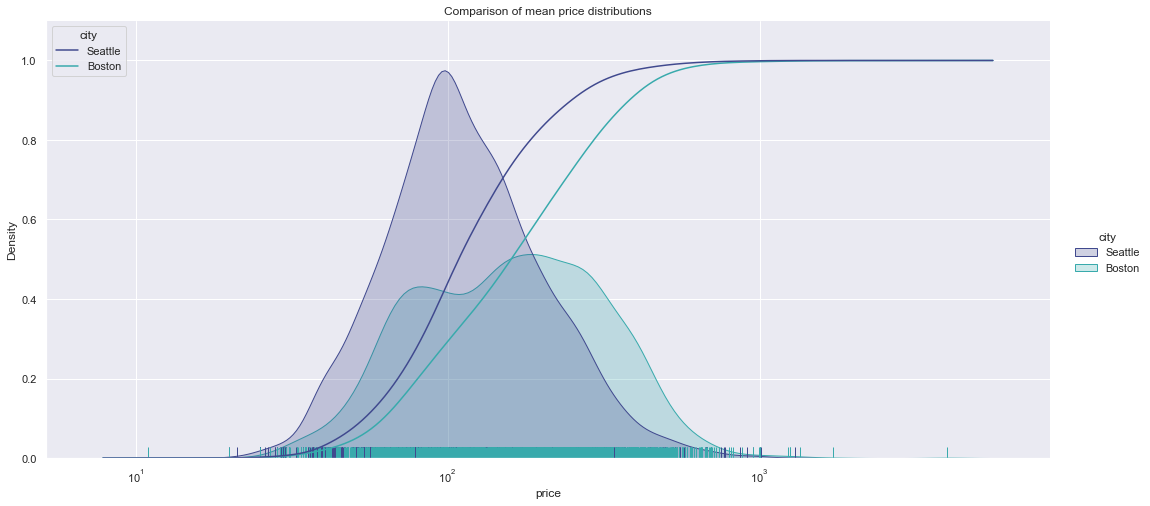

In [56]:
# Calculate the mean listing price for both cities
mean_price_seattle = df_seattle.groupby('listing_id').mean()['price'].to_frame().reset_index()
mean_price_seattle['city'] = 'Seattle'

mean_price_boston = df_boston.groupby('listing_id').mean()['price'].to_frame().reset_index()
mean_price_boston['city'] = 'Boston'

# Plot the probability density function of the mean prices
mean_prices = pd.concat([mean_price_seattle, mean_price_boston])
means_figure = sns.displot(data=mean_prices, x='price', kind='kde', hue='city', log_scale=True,fill=True, palette='mako', height=7, aspect=15/7, rug='True')
means_figure.set(title='Comparison of mean price distributions')

sns.kdeplot(
    data=mean_prices, x="price", hue="city",
    cumulative=True, common_norm=False, common_grid=True,palette='mako'
)

plt.savefig('figures/comparison_means.pdf', bbox_inches='tight')

#### b. Insight:

The probability density curve of prices for Seattle is symmetrical around the mean (135.76$)
By comparison, the Boston curve is flatter, shifted to the right and exhibits a local maximum 

### 2. Mann-Whitney U Test of mean price distributions:

#### a. Analysis:

In [28]:
# Overall mean listing price in Seattle
mean_price_seattle['price'].mean()

135.7640601537379

In [29]:
# Overall mean listing price in Boston
mean_price_boston['price'].mean()

196.9351274354401

In [30]:
# Calculate Mann-Whitney U test of the differences between means in Seattle and Boston
mannwhitneyu(mean_price_seattle['price'].to_list(), mean_price_boston['price'].to_list())

MannwhitneyuResult(statistic=3905616.0, pvalue=1.3978491233744973e-84)

#### b. Insight:

The Mann-Whitney U p-value (p<0.05) shows a significant difference between the distribution of mean accommodation prices in Seattle and Boston

### 3. Distribution of mean prices by accommodation type:

#### a. Analysis:

In [31]:
# Get the room type and number of guests to accommodate for each listing, for which we calculated the mean price
means_by_attributes_seattle = pd.merge(mean_price_seattle, df_listing_seattle[['id', 'room_type', 'accommodates']], left_on=['listing_id'], right_on = ['id'])
means_by_attributes_seattle.drop(columns = 'id', inplace=True)
means_by_attributes_seattle['price'] = means_by_attributes_seattle['price'].apply(lambda l: round(l,2))

means_by_attributes_boston = pd.merge(mean_price_boston, df_listing_boston[['id', 'room_type', 'accommodates']], left_on=['listing_id'], right_on = ['id'])
means_by_attributes_boston.drop(columns = 'id', inplace=True)
means_by_attributes_boston['price'] = means_by_attributes_boston['price'].apply(lambda l: round(l,2))

In [32]:
# Calculate the mean price by room type and number of guests to accommodate
grouped_seattle = means_by_attributes_seattle.groupby(['room_type', 'accommodates'])['price'].mean().reset_index(name='mean_price')
grouped_boston = means_by_attributes_boston.groupby(['room_type', 'accommodates'])['price'].mean().reset_index(name='mean_price')

grouped_seattle['city'] = 'Seattle'
grouped_boston['city'] = 'Boston'

#### b. Visualization:

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


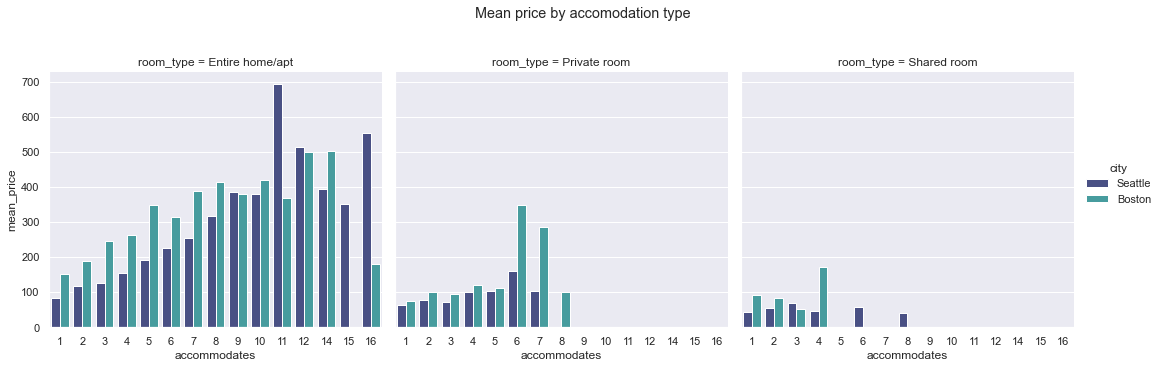

In [33]:
# Plot the price means by room type and number of guests to accommodate
fig_accomodation = sns.factorplot(x="accommodates", y="mean_price", hue="city", col="room_type", data=pd.concat([grouped_seattle, grouped_boston]), kind="bar", palette='mako')
fig_accomodation.fig.subplots_adjust(top=0.8)
fig_accomodation.fig.suptitle('Mean price by accomodation type')
plt.savefig('figures/distribution_means_by_column.pdf', bbox_inches='tight')

#### c. Insight:

The mean accommodation prices for up to 6 guests are consistently higher  in Boston than in Seattle accross all accommodation types (entire home/apt., private room and shared room).

### 4. Mann-Whitney U Test of mean price distributions by accommodation type:

#### a. Analysis:

In [54]:
# Get list of prices by room type and number of guests to accommodate in both cities
grouped_seattle = means_by_attributes_seattle.groupby(['room_type', 'accommodates'])['price'].apply(list).reset_index(name='values')
grouped_boston = means_by_attributes_boston.groupby(['room_type', 'accommodates'])['price'].apply(list).reset_index(name='values')

# Merge lists of values from both cities based on room type and number of guests to accommodate in both cities
df_diff_attribute = pd.merge(grouped_seattle, grouped_boston, left_on=['room_type', 'accommodates'], right_on = ['room_type', 'accommodates'])

# Calcluate Mann-Whitney U test of the difference of prices between groups of listings based on room type and number of guests to accommodate in both cities
df_diff_attribute['p-value'] = df_diff_attribute.apply(lambda row: round(mannwhitneyu(row['values_x'], row['values_y'])[1],3), axis=1)

# Add the sample size from each group for a better interpretation of the results
df_diff_attribute['sample_size_seattle'] = df_diff_attribute['values_x'].apply(lambda l: len(l))
df_diff_attribute['sample_size_boston'] = df_diff_attribute['values_y'].apply(lambda l: len(l))

# Display and highlicht significant differences between the groups
df_diff_attribute[['room_type', 'accommodates','sample_size_seattle', 'sample_size_boston', 'p-value']].style.apply(highlight_significant, subset=['p-value'], axis=1)

,room_type,accommodates,sample_size_seattle,sample_size_boston,p-value
0,Entire home/apt,1,18,16,0.002000
1,Entire home/apt,2,721,481,0.000000
2,Entire home/apt,3,319,301,0.000000
3,Entire home/apt,4,699,462,0.000000
4,Entire home/apt,5,171,206,0.000000
5,Entire home/apt,6,319,174,0.000000
6,Entire home/apt,7,47,34,0.000000
7,Entire home/apt,8,106,48,0.007000
8,Entire home/apt,9,12,10,0.205000
9,Entire home/apt,10,25,14,0.091000


#### c. Insight:

The results of the Mann-Whitney U test confirm our previous observation: accommodation prices are significantly higher in Boston than in Seattle forsmall number of guests

## Q2:  Which time of year is availability lowest in both cities?

### 1. Accommodation availability per month:

#### a. Analysis:

In [37]:
# Calculate the number of available listings per month and year
# Since price != nan means that a listing is available and since we have dropped all nan price rows, all listings in the remaining dataframe are available
group_bookings_seattle = df_seattle.groupby(['month', 'year'])['listing_id'].count()  #['listing_id'].unique().apply(len)
group_bookings_seattle = group_bookings_seattle.to_frame().rename(columns={'listing_id':'count'})

group_bookings_boston = df_boston.groupby(['month', 'year'])['listing_id'].count() #.unique().apply(len)
group_bookings_boston = group_bookings_boston.to_frame().rename(columns={'listing_id':'count'})

#### b. Visualization:

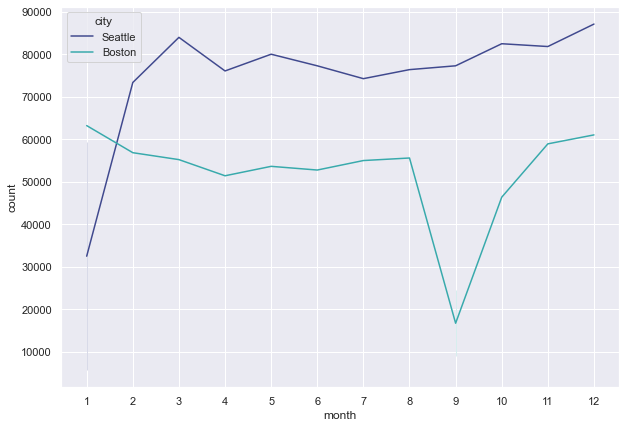

In [38]:
group_bookings_seattle['city'] = 'Seattle'
group_bookings_boston['city'] = 'Boston'

# Plot the number of available listings per month in both cities
sns.set(rc={'figure.figsize':(10,7)})
graph = sns.lineplot(data=pd.concat([group_bookings_seattle, group_bookings_boston]), palette='mako', x='month', y='count', hue='city')
# Set the x-axis labels to month numbers
graph.set_xticks(range(1,13)) 


plt.savefig('figures/available_per_month.pdf', bbox_inches='tight')

#### c. Insight:

The graph depicting accommodation availability by month in both cities shows that availability is at its lowest in Boston between August and October with a minimum in the month of September. As for Seattle, availability seems at its lowest between January and February.

### 2. Accommodation availability per day of year:

#### a. Analysis:

In [40]:
# Calculate the percentage of available listings per day
unique_listings_seattle = len(df_seattle['listing_id'].unique())
group_bookings_seattle = df_seattle.groupby(['date'])['listing_id'].unique().apply(len)/unique_listings_seattle
group_bookings_seattle = group_bookings_seattle.to_frame().reset_index().rename(columns={'listing_id':'count'})

unique_listings_boston = len(df_boston['listing_id'].unique())
group_bookings_boston = df_boston.groupby(['date'])['listing_id'].unique().apply(len)/unique_listings_boston
group_bookings_boston = group_bookings_boston.to_frame().reset_index().rename(columns={'listing_id':'count'})

#### b. Visualization:

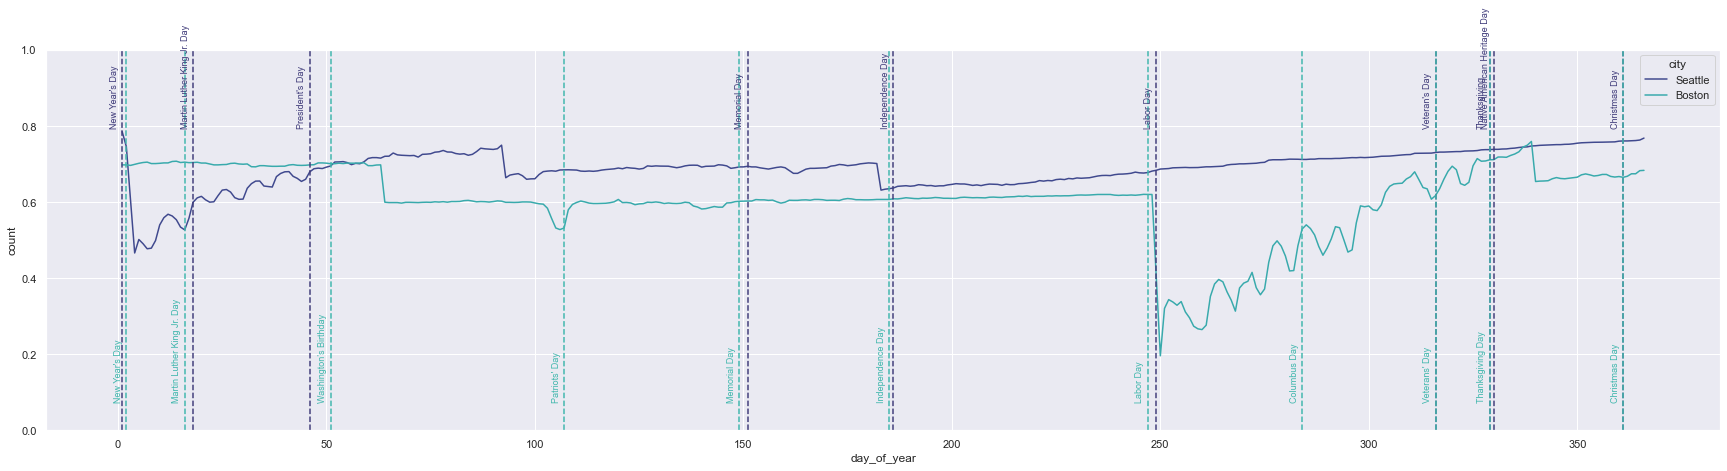

In [41]:
group_bookings_seattle['city'] = 'Seattle'
group_bookings_boston['city'] = 'Boston'

# Plot the percentage of available listings per day of the year
group_bookings_seattle['day_of_year'] = group_bookings_seattle['date'].dt.dayofyear
group_bookings_boston['day_of_year'] = group_bookings_boston['date'].dt.dayofyear

sns.set(rc={'figure.figsize':(30,7)})
graph = sns.lineplot(data=pd.concat([group_bookings_seattle, group_bookings_boston]), palette='mako', x='day_of_year', y='count', hue='city')
graph.set(ylim=(0, 1))

color_seattle = sns.color_palette("mako")[1]
color_boston = sns.color_palette("mako")[4]

# Plot axes of holiday dates in Boston and Seattle
holidays_seattle.apply(lambda row: draw_holiday(row['day_of_year'],row['holiday'], graph, color_seattle, 'top'), axis=1)
holidays_boston.apply(lambda row: draw_holiday(row['day_of_year'],row['holiday'], graph, color_boston, 'bottom'), axis=1)

plt.savefig('figures/availability_day_of_year.pdf', bbox_inches='tight')

#### c. Insight:

The plot of accommodation availability by day of year shows that availability drops slightly around Patriots' day and more significantly around Labor day in Boston. In Seattle, the drop in availability is experienced around the new year celebration.

### 3. Mean accommodation price per month:

#### a. Analysis & Visualization:

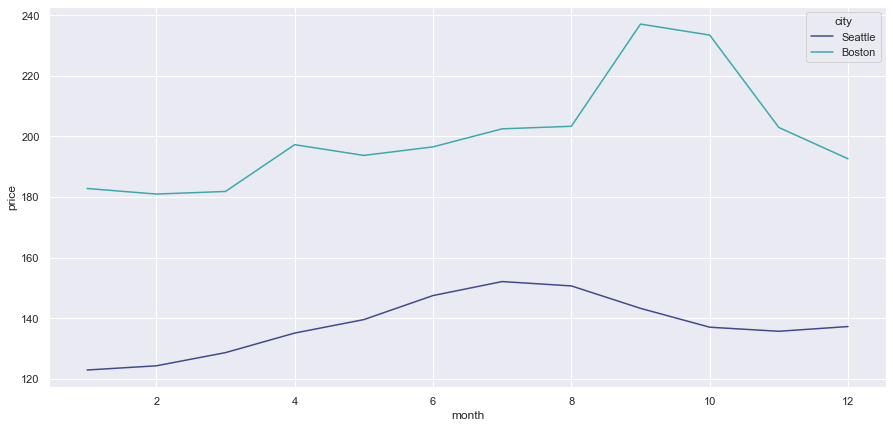

In [43]:
# Calculate and plot mean price by month for each city
mean_price_month_seattle = df_seattle.groupby(['month'])['price'].mean()
mean_price_month_seattle = mean_price_month_seattle.to_frame().reset_index()

mean_price_month_boston = df_boston.groupby(['month'])['price'].mean()
mean_price_month_boston = mean_price_month_boston.to_frame().reset_index()

mean_price_month_seattle['city'] = 'Seattle'
mean_price_month_boston['city'] = 'Boston'


sns.set(rc={'figure.figsize':(15,7)})
graph = sns.lineplot(data=pd.concat([mean_price_month_seattle, mean_price_month_boston]), palette='mako', x='month', y='price', hue='city')
plt.savefig('figures/price_per_month.pdf', bbox_inches='tight')

#### b. Insight:

The plot of mean prices by month concurs with previous results on availability. We can namely see a spike in accommodation prices in the months where availability is at its lowest. This is especially true for Boston. 

### 4. Mean accommodation price per day of year:

#### a. Analysis & Visualization:

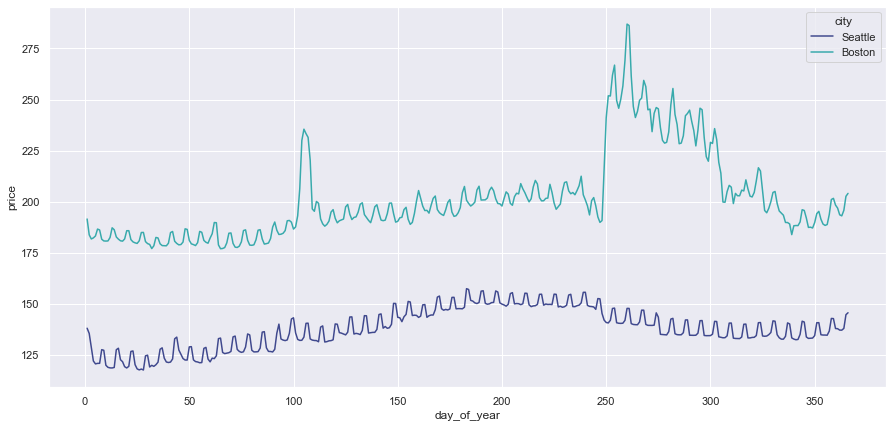

In [45]:
# Calculate and plot mean price by day of the year for each city
mean_price_month_seattle = df_seattle.groupby(['date'])['price'].mean()
mean_price_month_seattle = mean_price_month_seattle.to_frame().reset_index()

mean_price_month_boston = df_boston.groupby(['date'])['price'].mean()
mean_price_month_boston = mean_price_month_boston.to_frame().reset_index()

mean_price_month_seattle['city'] = 'Seattle'
mean_price_month_boston['city'] = 'Boston'

mean_price_month_seattle['day_of_year'] = mean_price_month_seattle['date'].dt.dayofyear
mean_price_month_boston['day_of_year'] = mean_price_month_boston['date'].dt.dayofyear

sns.set(rc={'figure.figsize':(15,7)})
graph = sns.lineplot(data=pd.concat([mean_price_month_seattle, mean_price_month_boston]), palette='mako', x='day_of_year', y='price', hue='city')

plt.savefig('figures/price_day_of_year.pdf', bbox_inches='tight')

#### b. Insight:

The plot of mean prices per day of the year confirms that the prices spike around the holidays where accommodation availability is at its lowest

## Q3. How do neighborhood and amenities correlate with price?

### 1. Correlation of price with neighborhood:

#### a. Analysis:

In [47]:
# Get the list of neighborhoods for both cities
neighbourhoods_seattle = df_seattle['neighbourhood'].unique()
neighbourhoods_seattle = [n for n in neighbourhoods_seattle if not pd.isnull(n)]

neighbourhoods_boston = df_boston['neighbourhood'].unique()
neighbourhoods_boston = [n for n in neighbourhoods_boston if not pd.isnull(n)]

In [48]:
# Add binary columns with neoghborhood for each listing
df_neighbourhood_seattle = df_seattle[['listing_id', 'neighbourhood', 'price']]
df_neighbourhood_seattle.dropna(subset=['neighbourhood'], inplace=True)
col_to_binary(df_neighbourhood_seattle, 'neighbourhood', neighbourhoods_seattle)

df_neighbourhood_boston = df_boston[['listing_id', 'neighbourhood', 'price']]
df_neighbourhood_boston.dropna(subset=['neighbourhood'], inplace=True)
col_to_binary(df_neighbourhood_boston, 'neighbourhood', neighbourhoods_boston)

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

#### b. Visualization:

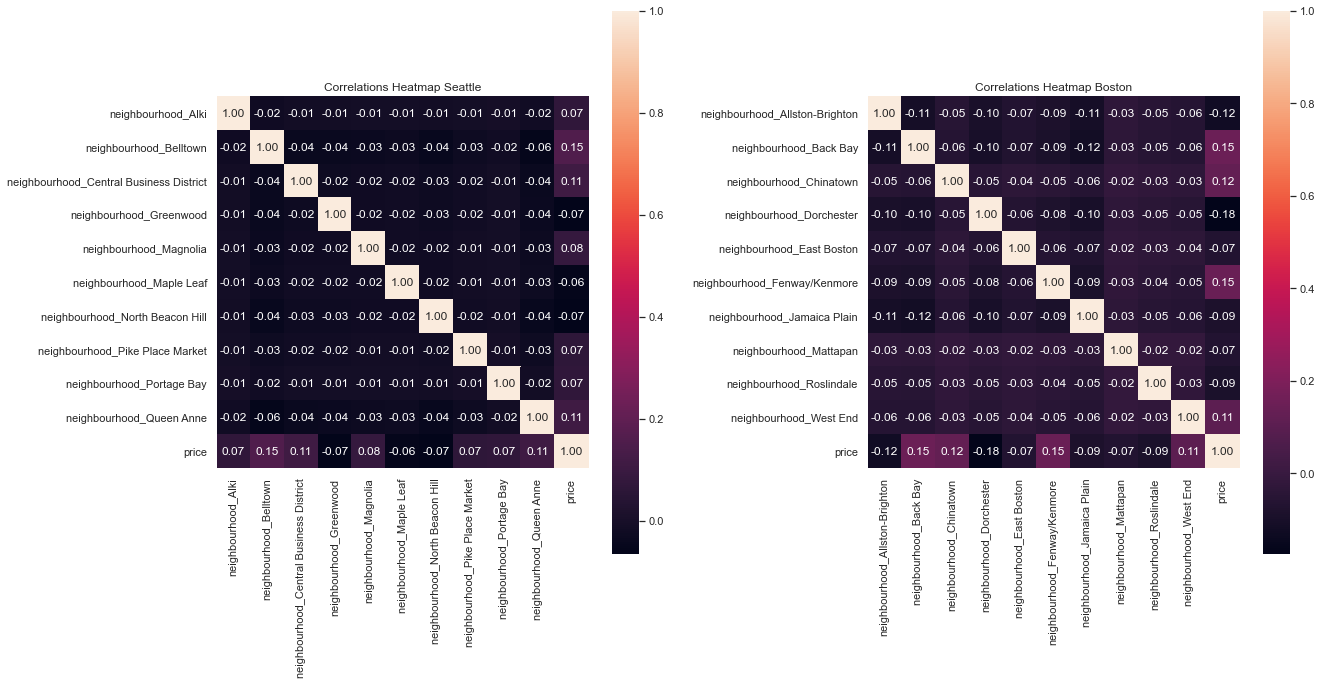

In [60]:
cols_seattle = ['neighbourhood_' + c for c in neighbourhoods_seattle]
cols_boston = ['neighbourhood_' + c for c in neighbourhoods_boston]

# Calculate the top 10 neighborhoods correlating with price
top_neighborhoods_seattle_cols = get_top_corr_columns(10, df_neighbourhood_seattle, ['price'] + cols_seattle)
top_neighborhoods_boston_cols = get_top_corr_columns(10, df_neighbourhood_boston, ['price'] + cols_boston)

# Plot heatmaps of top correlating neighborhoods
corr_seattle = np.corrcoef(df_neighbourhood_seattle[top_neighborhoods_seattle_cols].values.T)
corr_boston = np.corrcoef(df_neighbourhood_boston[top_neighborhoods_boston_cols].values.T)

sns.set(rc={'figure.figsize':(15,15)})
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=3)
sns.set(font_scale=1)


heatmap_seattle = sns.heatmap(corr_seattle, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels =top_neighborhoods_seattle_cols , xticklabels = top_neighborhoods_seattle_cols, ax=ax1).set_title('Correlations Heatmap Seattle')

heatmap_boston = sns.heatmap(corr_boston, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels =top_neighborhoods_boston_cols , xticklabels = top_neighborhoods_boston_cols, ax=ax2).set_title('Correlations Heatmap Boston')

plt.savefig('figures/neighbourhood_correlation_top_10.pdf', bbox_inches='tight')

#### c. Insight:

The heatmap shows that neighbourhoods such as Belltown, the central business district and Queen Anne have the highest correlation with price in the city of Seattle. In Boston, accommodation price seem to be higher in neighbourhoods such as Back Bay, Fenway/Kenmore and China Town.

### 2. Correlation of price with amenities:

#### a. Analysis & Visualization:

In [51]:
amenities_seattle = [col for col in df_listing_seattle if col.startswith('has_') and col != 'has_availability']
amenities_boston = [col for col in df_listing_boston if col.startswith('has_') and col != 'has_availability']

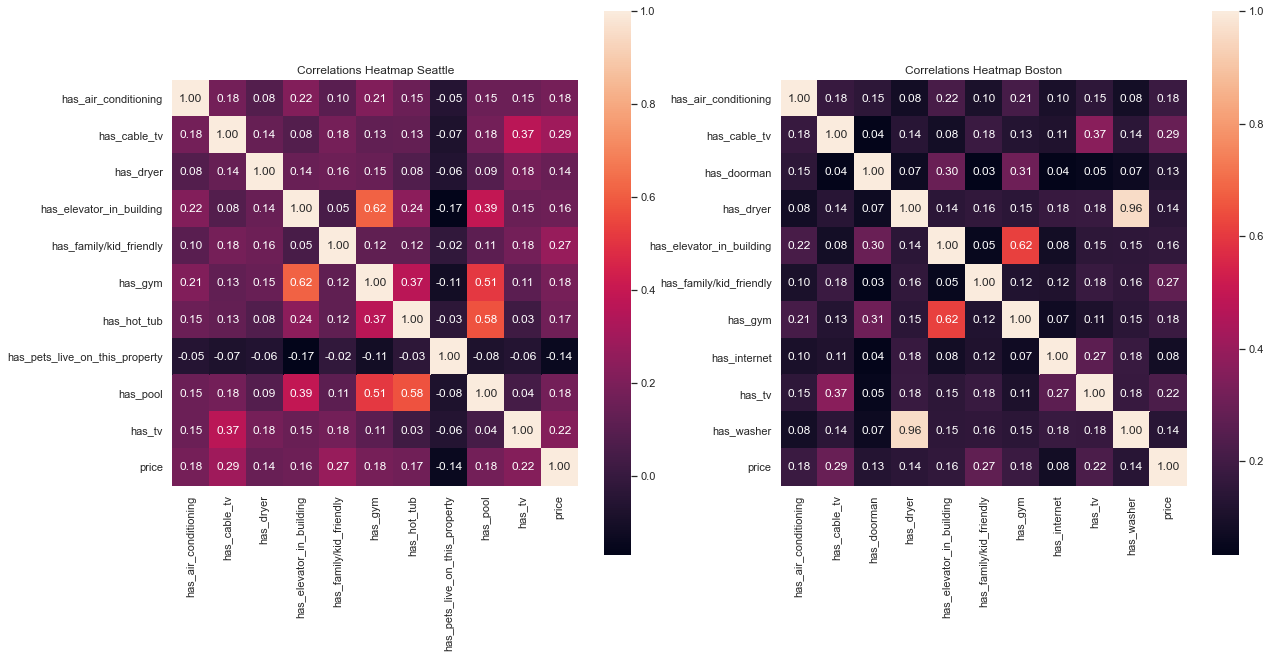

In [52]:
# Calculate the top 10 amenities correlating with price
top_amenities_seattle_cols = get_top_corr_columns(10, df_seattle, ['price'] + amenities_seattle)
top_amenities_boston_cols = get_top_corr_columns(10, df_boston, ['price'] + amenities_boston)

corr_seattle = np.corrcoef(df_seattle[top_amenities_seattle_cols].values.T)
corr_boston = np.corrcoef(df_seattle[top_amenities_boston_cols].values.T)

# Plot heatmaps of top correlating amenities
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
sns.set(font_scale=1)

heatmap_seattle = sns.heatmap(corr_seattle, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels =top_amenities_seattle_cols , xticklabels = top_amenities_seattle_cols, ax=ax1).set_title('Correlations Heatmap Seattle')

heatmap_boston = sns.heatmap(corr_boston, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels =top_amenities_boston_cols , xticklabels = top_amenities_boston_cols, ax=ax2).set_title('Correlations Heatmap Boston')

plt.savefig('figures/amenities_correlation_top_10.pdf', bbox_inches='tight')

#### c. Insight:

The heatmap shows that amenities such as Cable TV and family and kid-friendliness have the highest correlation with price in both Seattle and Boston. In Seattle in particular, accommodation prices seem to be lower when a pet lives on the property.